In [106]:
import numpy as np
import matplotlib.pyplot as plt

import zipfile
from skimage import color
from skimage import io
import os

from keras.models import Sequential,Input  #Keras traz uma abstração das redes neurais
from keras.layers import Dense
from keras.utils import np_utils

from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Funções para tratamento e obtenção da base de dados para treino e teste da Rede neural

In [120]:
def extract_from_zip(path_zip,path_dest):
  arq = zipfile.ZipFile(path_zip)
  arq.extractall(path_dest)
  arq.close()

In [121]:
def get_matrix(path_img,like_array):
  try:
    img = io.imread(path_img)
    img_gray = color.rgb2gray(img)
    if like_array:
      img_gray = img_gray.reshape(1,img_gray.shape[0]*img_gray.shape[1])[0]
    return img_gray
  except FileNotFoundError:
    return -1 #sim, ocorreu um erro

In [122]:
def built_targets_matrix(label_counts):

  m = sum(label_counts[:,1])
  n = len(label_counts)

  y = np.zeros((m,n))

  ini = 0
  for i in label_counts:
    y[ini:ini+i[1],i[0]] = 1
    ini += i[1]
    
  return y

In [123]:
def built_grand_matrix_and_targets(path,type_arq,as_array=True): #path da pasta geral
  X = []
  labels = []
  for p in os.listdir(path):
    complete_path = os.path.join(path, p)
    
    count_for_label = get_data_from_direct(complete_path,type_arq,as_array,X)

    labels.append([int(p),count_for_label])
  
  y = built_targets_matrix(np.array(labels))

  return np.array(X),y

In [124]:
def get_data_from_direct(path,type_arq,as_array,X):

  for image_name in os.listdir(path):
      
      if not type_arq in image_name: continue 
      input_path = os.path.join(path, image_name)
      data = get_matrix(input_path,as_array)
      if type(data) != np.ndarray:continue

      X.append(data)
  
  return len(os.listdir(path))

Sliding windows

In [125]:
def sliding_windows(m_img,m_pixels,n_pixels,steps): #mxn matrix

  ini_i = 0
  for i in range(m_pixels-1,m_img.shape[0],steps):
    ini_j = 0
    for j in range(n_pixels-1,m_img.shape[1],steps):
      print(m_img[ini_i:i+1,ini_j:j+1].shape)
      # Código para decidir oq fazer com o slice pego da matriz
      ini_j += steps

    ini_i += steps

#Rede Neural

In [126]:
from keras.backend import argmax
class neural_network:
  def __init__(self,input_layer_dim,X,y):
    self.model = Sequential()
    self.have_input = False
    self.input_layer_dim = input_layer_dim
    self.X_train,self.X_test,self.y_train,self.y_test = train_test_split(X,y,test_size = 0.3)
  
  def summary(self):
    return self.model.summary()

  def add_layer(self,units_dim,activation_f):
    if not self.have_input:
      self.model.add(Input(shape=(self.input_layer_dim)))
      #self.model.add(Dense(units=units_dim,input_dim = self.input_layer_dim, activation = activation_f))
      self.have_input = True
    #else:
    self.model.add(Dense(units=units_dim,activation = activation_f))
  
  def train_network(self,epochs):
    self.model.compile(optimizer='sgd',loss='categorical_crossentropy',
                       metrics=['accuracy'])

    self.model.fit(self.X_train,self.y_train,epochs=epochs,
                   validation_data=(self.X_test,self.y_test))
  
  def predict_class(self,example):
    return argmax(self.model.predict(example)).numpy()[0]


#Construindo a rede e executando testes

In [127]:
extract_from_zip('/content/drive/MyDrive/training_set.zip','/content/set')

In [128]:
X,y = built_grand_matrix_and_targets('/content/set','.jpg')
print(f'{X.shape};{y.shape}')

(42000, 784);(42000, 10)


In [129]:
rn = neural_network(28*28,X,y)

rn.add_layer(400,'sigmoid')
rn.add_layer(80,'sigmoid')
rn.add_layer(10,'sigmoid')

rn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 400)               314000    
                                                                 
 dense_18 (Dense)            (None, 80)                32080     
                                                                 
 dense_19 (Dense)            (None, 10)                810       
                                                                 
Total params: 346,890
Trainable params: 346,890
Non-trainable params: 0
_________________________________________________________________


In [130]:
rn.train_network(epochs=10)

Epoch 1/10
919/919 [==============================] - 5s 6ms/step - loss: 1.3641 - accuracy: 0.7221 - val_loss: 0.8219 - val_accuracy: 0.8435
Epoch 2/10
919/919 [==============================] - 5s 5ms/step - loss: 0.6353 - accuracy: 0.8716 - val_loss: 0.5239 - val_accuracy: 0.8834
Epoch 3/10
919/919 [==============================] - 5s 5ms/step - loss: 0.4469 - accuracy: 0.8958 - val_loss: 0.4160 - val_accuracy: 0.8963
Epoch 4/10
919/919 [==============================] - 5s 5ms/step - loss: 0.3657 - accuracy: 0.9100 - val_loss: 0.3603 - val_accuracy: 0.9068
Epoch 5/10
919/919 [==============================] - 4s 5ms/step - loss: 0.3182 - accuracy: 0.9182 - val_loss: 0.3281 - val_accuracy: 0.9142
Epoch 6/10
919/919 [==============================] - 4s 5ms/step - loss: 0.2864 - accuracy: 0.9248 - val_loss: 0.3079 - val_accuracy: 0.9172
Epoch 7/10
919/919 [==============================] - 5s 5ms/step - loss: 0.2617 - accuracy: 0.9312 - val_loss: 0.2839 - val_accuracy: 0.9225
Epoch 

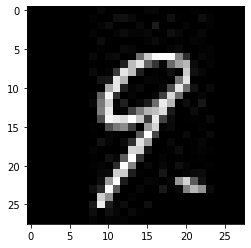

In [107]:
im = get_matrix('/content/img_3.jpg',False)
plt.gray()
plt.imshow(im)

In [108]:
rn.predict_class(im.reshape(1,28*28))

9